# Reinforcement Learning: Zero to Hero - Part 4/17

**Cells 61-80 of 291**



In [29]:
def policy_improvement(mdp, V, gamma=0.9):
    """Improve a policy by acting greedily with respect to value function.
    
    Args:
        mdp: MDP object
        V: Value function (dict: state -> value)
        gamma: Discount factor
        
    Returns:
        new_policy: Improved policy (dict: state -> {action: probability})
        policy_stable: Boolean indicating if policy changed
    """
    new_policy = {}
    policy_stable = True
    
    for state in mdp.states:
        # Calculate Q(s,a) for all actions
        q_values = {}
        
        for action in mdp.actions:
            q = 0.0
            next_states = mdp.transitions.get((state, action), {})
            
            for next_state, trans_prob in next_states.items():
                reward = mdp.rewards.get((state, action, next_state), 0.0)
                q += trans_prob * (reward + gamma * V[next_state])
            
            q_values[action] = q
        
        # Choose action(s) with maximum Q-value
        if q_values:
            max_q = max(q_values.values())
            best_actions = [a for a, q in q_values.items() if np.isclose(q, max_q)]
            
            # Create deterministic policy (or uniform over best actions if tie)
            new_policy[state] = {a: 1.0/len(best_actions) for a in best_actions}
    
    return new_policy, policy_stable


def policy_iteration(mdp, gamma=0.9, theta=0.0001, max_iterations=100):
    """Find optimal policy using policy iteration.
    
    Args:
        mdp: MDP object
        gamma: Discount factor
        theta: Convergence threshold for policy evaluation
        max_iterations: Maximum number of policy iterations
        
    Returns:
        policy: Optimal policy
        V: Optimal value function
        num_iterations: Number of iterations
    """
    # Initialize with random policy
    policy = {}
    for state in mdp.states:
        # Uniform random policy
        policy[state] = {a: 1.0/len(mdp.actions) for a in mdp.actions}
    
    for iteration in range(max_iterations):
        # Policy Evaluation
        V, _ = policy_evaluation(mdp, policy, gamma, theta, max_iterations=1000)
        
        # Policy Improvement
        new_policy, policy_stable = policy_improvement(mdp, V, gamma)
        
        # Check if policy has converged
        if policies_equal(policy, new_policy):
            print(f"Policy iteration converged in {iteration + 1} iterations")
            return new_policy, V, iteration + 1
        
        policy = new_policy
    
    print(f"Policy iteration reached max iterations ({max_iterations})")
    return policy, V, max_iterations


def policies_equal(policy1, policy2):
    """Check if two policies are equal."""
    if set(policy1.keys()) != set(policy2.keys()):
        return False
    
    for state in policy1:
        actions1 = policy1[state]
        actions2 = policy2.get(state, {})
        
        if set(actions1.keys()) != set(actions2.keys()):
            return False
        
        for action in actions1:
            if not np.isclose(actions1[action], actions2.get(action, 0)):
                return False
    
    return True


# Demonstrate policy iteration on 2x2 grid
print("Policy Iteration Demonstration")
print("="*60)

print("Finding optimal policy for 2x2 Grid World...")

# Run policy iteration
optimal_policy, optimal_V, num_iters = policy_iteration(mdp, gamma=0.9, theta=0.0001)

print("" + "="*60)
print("Optimal Policy π*:")
print("-"*60)
for state in states:
    actions_str = ", ".join([f"{a}({p:.2f})" for a, p in optimal_policy[state].items() if p > 0])
    print(f"  π*({state}) = {actions_str}")

print("Optimal Value Function V*:")
print("-"*60)
for state in states:
    print(f"  V*({state}) = {optimal_V[state]:7.4f}")

print("" + "="*60)
print("💡 Interpretation:")
print("   - Policy iteration found the optimal policy")
print("   - From (0,0): Go RIGHT to (0,1)")
print("   - From (0,1): Go DOWN to goal (1,1)")
print("   - From (1,0): Go RIGHT to goal (1,1)")
print("   - This is the shortest path to the goal!")

Policy Iteration Demonstration
Finding optimal policy for 2x2 Grid World...
Policy evaluation converged in 16 iterations
Policy evaluation converged in 3 iterations
Policy iteration converged in 2 iterations
Optimal Policy π*:
------------------------------------------------------------
  π*((0,0)) = RIGHT(0.50), DOWN(0.50)
  π*((0,1)) = DOWN(1.00)
  π*((1,0)) = RIGHT(1.00)
  π*((1,1)) = RIGHT(0.50), DOWN(0.50)
Optimal Value Function V*:
------------------------------------------------------------
  V*((0,0)) =  8.0000
  V*((0,1)) = 10.0000
  V*((1,0)) = 10.0000
  V*((1,1)) =  0.0000
💡 Interpretation:
   - Policy iteration found the optimal policy
   - From (0,0): Go RIGHT to (0,1)
   - From (0,1): Go DOWN to goal (1,1)
   - From (1,0): Go RIGHT to goal (1,1)
   - This is the shortest path to the goal!


#### Value Iteration: A More Efficient Approach

**Combining Evaluation and Improvement**

Policy iteration works well but can be slow because it fully evaluates each policy. **Value iteration** provides a more efficient alternative by combining evaluation and improvement into a single update.

**Value Iteration Algorithm:**

Instead of alternating between full policy evaluation and improvement, value iteration updates values using the Bellman optimality equation:

$V_{k+1}(s) = \max_a \sum_{s'} P(s'|s,a) \left[R(s,a,s') + \gamma V_k(s')\right]$

**Algorithm:**

```
1. Initialize V(s) = 0 for all states
2. Repeat until convergence:
   For each state s:
     V(s) ← max_a Σ P(s'|s,a)[R(s,a,s') + γV(s')]
3. Extract policy: π(s) = argmax_a Σ P(s'|s,a)[R(s,a,s') + γV(s')]
```

**Key Differences from Policy Iteration:**

1. **No explicit policy**: Works directly with value function
2. **Single update**: Combines evaluation and improvement
3. **Faster convergence**: Often requires fewer iterations
4. **Simpler implementation**: No need to track policy during iteration

**Why Value Iteration Works:**

- Each update moves V closer to V*
- The max operator implicitly improves the policy
- Guaranteed to converge to V* (and thus π*)
- Convergence rate is exponential in γ

**Relationship to Policy Iteration:**

Value iteration is like policy iteration with just one sweep of policy evaluation per iteration. Both converge to the same optimal solution, but value iteration is often faster in practice.

Let's implement value iteration!

In [30]:
def value_iteration(mdp, gamma=0.9, theta=0.0001, max_iterations=1000):
    """Find optimal value function and policy using value iteration.
    
    Args:
        mdp: MDP object
        gamma: Discount factor
        theta: Convergence threshold
        max_iterations: Maximum number of iterations
        
    Returns:
        V: Optimal value function
        policy: Optimal policy
        num_iterations: Number of iterations
    """
    # Initialize value function
    V = {s: 0.0 for s in mdp.states}
    
    for iteration in range(max_iterations):
        delta = 0
        V_new = V.copy()
        
        # Update each state
        for state in mdp.states:
            # Calculate max over actions
            action_values = []
            
            for action in mdp.actions:
                q = 0.0
                next_states = mdp.transitions.get((state, action), {})
                
                for next_state, trans_prob in next_states.items():
                    reward = mdp.rewards.get((state, action, next_state), 0.0)
                    q += trans_prob * (reward + gamma * V[next_state])
                
                action_values.append(q)
            
            # Bellman optimality update
            if action_values:
                V_new[state] = max(action_values)
                delta = max(delta, abs(V_new[state] - V[state]))
        
        V = V_new
        
        # Check convergence
        if delta < theta:
            print(f"Value iteration converged in {iteration + 1} iterations")
            
            # Extract optimal policy
            policy = {}
            for state in mdp.states:
                q_values = {}
                for action in mdp.actions:
                    q = 0.0
                    next_states = mdp.transitions.get((state, action), {})
                    for next_state, trans_prob in next_states.items():
                        reward = mdp.rewards.get((state, action, next_state), 0.0)
                        q += trans_prob * (reward + gamma * V[next_state])
                    q_values[action] = q
                
                # Greedy policy
                if q_values:
                    max_q = max(q_values.values())
                    best_actions = [a for a, q in q_values.items() if np.isclose(q, max_q)]
                    policy[state] = {a: 1.0/len(best_actions) for a in best_actions}
            
            return V, policy, iteration + 1
    
    print(f"Value iteration reached max iterations ({max_iterations})")
    
    # Extract policy even if not converged
    policy = {}
    for state in mdp.states:
        q_values = {}
        for action in mdp.actions:
            q = 0.0
            next_states = mdp.transitions.get((state, action), {})
            for next_state, trans_prob in next_states.items():
                reward = mdp.rewards.get((state, action, next_state), 0.0)
                q += trans_prob * (reward + gamma * V[next_state])
            q_values[action] = q
        
        if q_values:
            max_q = max(q_values.values())
            best_actions = [a for a, q in q_values.items() if np.isclose(q, max_q)]
            policy[state] = {a: 1.0/len(best_actions) for a in best_actions}
    
    return V, policy, max_iterations


# Demonstrate value iteration
print("Value Iteration Demonstration")
print("="*60)

print("Finding optimal policy for 2x2 Grid World using Value Iteration...")

# Run value iteration
V_opt, policy_opt, num_iters_vi = value_iteration(mdp, gamma=0.9, theta=0.0001)

print("" + "="*60)
print("Optimal Policy π* (from Value Iteration):")
print("-"*60)
for state in states:
    actions_str = ", ".join([f"{a}({p:.2f})" for a, p in policy_opt[state].items() if p > 0])
    print(f"  π*({state}) = {actions_str}")

print("Optimal Value Function V*:")
print("-"*60)
for state in states:
    print(f"  V*({state}) = {V_opt[state]:7.4f}")

print("" + "="*60)
print("💡 Comparison: Policy Iteration vs Value Iteration")
print("  Both methods found the same optimal solution!")
print(f"  Policy Iteration: {num_iters} iterations")
print(f"  Value Iteration: {num_iters_vi} iterations")
print("  Value iteration is often faster because it doesn't")
print("  fully evaluate each intermediate policy.")

Value Iteration Demonstration
Finding optimal policy for 2x2 Grid World using Value Iteration...
Value iteration converged in 3 iterations
Optimal Policy π* (from Value Iteration):
------------------------------------------------------------
  π*((0,0)) = RIGHT(0.50), DOWN(0.50)
  π*((0,1)) = DOWN(1.00)
  π*((1,0)) = RIGHT(1.00)
  π*((1,1)) = RIGHT(0.50), DOWN(0.50)
Optimal Value Function V*:
------------------------------------------------------------
  V*((0,0)) =  8.0000
  V*((0,1)) = 10.0000
  V*((1,0)) = 10.0000
  V*((1,1)) =  0.0000
💡 Comparison: Policy Iteration vs Value Iteration
  Both methods found the same optimal solution!
  Policy Iteration: 2 iterations
  Value Iteration: 3 iterations
  Value iteration is often faster because it doesn't
  fully evaluate each intermediate policy.


#### Visualizing Value Iteration on 4x4 Grid

Value Iteration on 4x4 Grid World
Running value iteration on 4x4 grid with obstacles...
Value iteration converged in 89 iterations


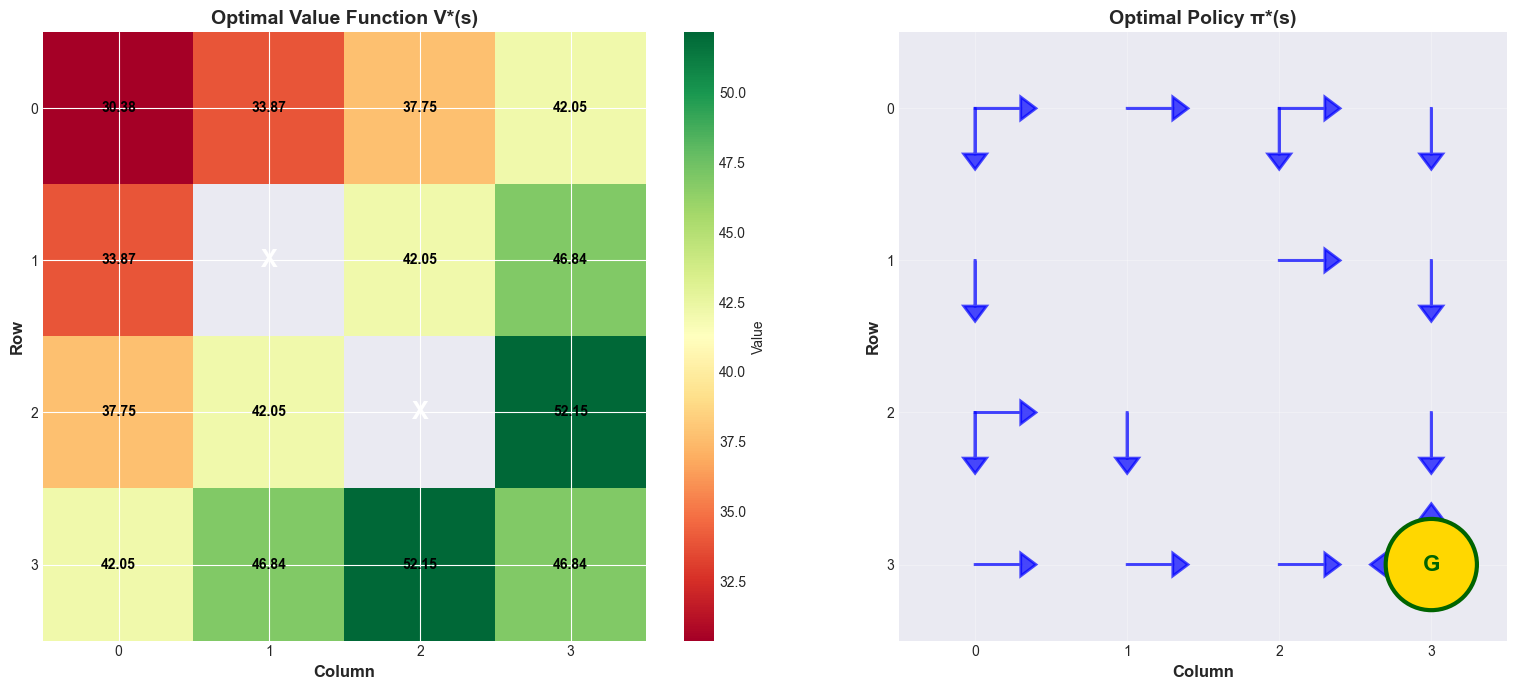

📊 Results:
Converged in 89 iterations
Optimal policy shows the best action in each state
Arrows point towards the goal, avoiding obstacles
💡 Key Insights:
   1. Value iteration found the optimal policy efficiently
   2. Policy directs agent towards goal from any state
   3. Obstacles are naturally avoided
   4. V*(s) reflects optimal expected return from each state
   5. This is the foundation for solving MDPs!


In [31]:
# Apply value iteration to the larger 4x4 grid world
print("Value Iteration on 4x4 Grid World")
print("="*60)

print("Running value iteration on 4x4 grid with obstacles...")

# Run value iteration
V_grid_opt, policy_grid_opt, num_iters_grid = value_iteration(grid_mdp, gamma=0.9, theta=0.001)

# Visualize optimal value function
value_grid_opt = np.full((4, 4), np.nan)
for state_str, value in V_grid_opt.items():
    state = eval(state_str)
    value_grid_opt[state[0], state[1]] = value

# Create visualization with optimal policy arrows
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Optimal Value Function
masked_grid = np.ma.masked_where(np.isnan(value_grid_opt), value_grid_opt)
im1 = ax1.imshow(masked_grid, cmap='RdYlGn', aspect='auto', interpolation='nearest')
ax1.set_xticks(range(4))
ax1.set_yticks(range(4))
ax1.set_xlabel('Column', fontsize=12, fontweight='bold')
ax1.set_ylabel('Row', fontsize=12, fontweight='bold')
ax1.set_title('Optimal Value Function V*(s)', fontsize=14, fontweight='bold')

# Add value labels
for i in range(4):
    for j in range(4):
        if not np.isnan(value_grid_opt[i, j]):
            ax1.text(j, i, f'{value_grid_opt[i, j]:.2f}',
                    ha="center", va="center", color="black", 
                    fontsize=10, fontweight='bold')
        else:
            ax1.text(j, i, 'X', ha="center", va="center", 
                    color="white", fontsize=18, fontweight='bold')

plt.colorbar(im1, ax=ax1, label='Value')

# Plot 2: Optimal Policy
ax2.set_xlim(-0.5, 3.5)
ax2.set_ylim(-0.5, 3.5)
ax2.set_aspect('equal')
ax2.set_xticks(range(4))
ax2.set_yticks(range(4))
ax2.set_xlabel('Column', fontsize=12, fontweight='bold')
ax2.set_ylabel('Row', fontsize=12, fontweight='bold')
ax2.set_title('Optimal Policy π*(s)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.invert_yaxis()

# Draw policy arrows
arrow_map = {'UP': (0, -0.3), 'DOWN': (0, 0.3), 'LEFT': (-0.3, 0), 'RIGHT': (0.3, 0)}

for state_str, actions in policy_grid_opt.items():
    state = eval(state_str)
    i, j = state
    
    # Skip obstacles
    if (i, j) in [(1, 1), (2, 2)]:
        ax2.add_patch(plt.Rectangle((j-0.4, i-0.4), 0.8, 0.8, 
                                    fill=True, facecolor='gray', edgecolor='black', linewidth=2))
        ax2.text(j, i, 'X', ha='center', va='center', 
                color='white', fontsize=18, fontweight='bold')
        continue
    
    # Draw arrows for best action(s)
    for action, prob in actions.items():
        if prob > 0.1:  # Only draw if significant probability
            dx, dy = arrow_map.get(action, (0, 0))
            ax2.arrow(j, i, dx, dy, head_width=0.15, head_length=0.1,
                     fc='blue', ec='blue', linewidth=2, alpha=0.7)

# Mark goal
ax2.add_patch(plt.Circle((3, 3), 0.3, fill=True, facecolor='gold', 
                         edgecolor='darkgreen', linewidth=3))
ax2.text(3, 3, 'G', ha='center', va='center', 
        color='darkgreen', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Results:")
print("="*60)
print(f"Converged in {num_iters_grid} iterations")
print("Optimal policy shows the best action in each state")
print("Arrows point towards the goal, avoiding obstacles")

print("💡 Key Insights:")
print("   1. Value iteration found the optimal policy efficiently")
print("   2. Policy directs agent towards goal from any state")
print("   3. Obstacles are naturally avoided")
print("   4. V*(s) reflects optimal expected return from each state")
print("   5. This is the foundation for solving MDPs!")

<a id='learning-paradigms'></a>
#### Model-Based vs Model-Free Reinforcement Learning

**A Fundamental Distinction in RL**

Now that we've seen Dynamic Programming in action, it's important to understand a fundamental distinction in reinforcement learning: **model-based** vs **model-free** approaches.

**Model-Based Reinforcement Learning**

**Definition:** The agent has (or learns) a model of the environment's dynamics.

**What is a "model"?**
- Transition probabilities: $P(s'|s,a)$
- Reward function: $R(s,a,s')$
- Essentially, knowledge of how the environment works

**Examples:**
- Dynamic Programming (what we just learned!)
- Planning algorithms
- Simulators (e.g., chess, Go, robotics simulators)
- Learned models (agent learns $P$ and $R$ from experience)

**Advantages of Model-Based RL:**

1. **Sample Efficiency**: Can plan without interacting with environment
   - Simulate many trajectories mentally
   - No need to try every action in every state
   - Particularly valuable when real-world interactions are expensive

2. **Faster Learning**: Can use planning algorithms
   - Dynamic Programming guarantees optimal solution
   - Can reason about consequences before acting
   - Update values for all states simultaneously

3. **Generalization**: Model can be used for multiple tasks
   - Same model, different reward functions
   - Transfer learning across related problems
   - What-if analysis and counterfactual reasoning

4. **Interpretability**: Can understand and debug the model
   - Inspect transition probabilities
   - Verify model correctness
   - Explain agent's reasoning

**Disadvantages of Model-Based RL:**

1. **Model Errors**: If model is wrong, policy will be suboptimal
   - "All models are wrong, but some are useful"
   - Model errors compound over long horizons
   - Difficult to model complex, stochastic environments

2. **Computational Cost**: Planning can be expensive
   - Need to solve Bellman equations
   - Scales poorly with state/action space size
   - Curse of dimensionality

3. **Model Learning**: Learning accurate models is hard
   - Requires lots of data
   - High-dimensional state spaces are challenging
   - Stochastic environments are difficult to model

4. **Availability**: Many real-world problems lack good models
   - Human behavior is hard to model
   - Complex physical systems
   - Unknown or changing dynamics

**Model-Free Reinforcement Learning**

**Definition:** The agent learns directly from experience without a model.

**What does "model-free" mean?**
- No knowledge of $P(s'|s,a)$ or $R(s,a,s')$
- Learns value functions or policies directly
- Trial-and-error learning

**Examples:**
- Monte Carlo methods
- Temporal Difference learning (TD, SARSA, Q-learning)
- Policy gradient methods
- Deep RL (DQN, A3C, PPO)

**Advantages of Model-Free RL:**

1. **No Model Required**: Works when model is unknown or complex
   - Don't need to know environment dynamics
   - Can handle black-box environments
   - Robust to model misspecification

2. **Simpler**: Often easier to implement
   - Direct learning from experience
   - No need to learn or maintain a model
   - Fewer components to debug

3. **Scalability**: Can use function approximation
   - Neural networks for large state spaces
   - Generalization across states
   - Handles continuous state/action spaces

4. **Robustness**: Less sensitive to model errors
   - Learns from actual experience
   - Adapts to environment changes
   - No compounding of model errors

**Disadvantages of Model-Free RL:**

1. **Sample Inefficiency**: Requires many interactions
   - Must try actions to learn their value
   - Can't simulate or plan ahead
   - Expensive in real-world applications

2. **Slower Learning**: No planning capability
   - Must experience each state-action pair
   - Can't reason about consequences
   - Updates are local (one state at a time)

3. **Exploration Challenges**: Must balance exploration/exploitation
   - Risk of getting stuck in local optima
   - May miss better strategies
   - Requires careful exploration strategy

4. **No Generalization Across Tasks**: Learns for specific reward
   - Must relearn if reward function changes
   - Limited transfer learning
   - Task-specific knowledge

**Why Model-Free Methods Are Needed**

Despite the advantages of model-based RL, model-free methods are essential because:

1. **Real-World Complexity**: Most real-world environments are too complex to model accurately
   - Human interactions, market dynamics, weather patterns
   - High-dimensional, stochastic, non-stationary

2. **Unknown Dynamics**: Often we don't know how the environment works
   - Black-box systems
   - Proprietary or inaccessible internals

3. **Model Errors Are Costly**: Wrong models lead to wrong policies
   - Model-free methods learn from ground truth
   - More robust in practice

4. **Scalability**: Model-free + function approximation handles large spaces
   - Deep RL successes (Atari, Go, robotics)
   - Continuous control problems

5. **Simplicity**: Easier to implement and debug
   - Fewer moving parts
   - Direct optimization of objective

**The Spectrum: Hybrid Approaches**

Modern RL often combines both approaches:

- **Dyna**: Model-free learning + model-based planning
- **Model-Based RL with Learned Models**: Learn model from data, use for planning
- **Imagination-Augmented Agents**: Use model for auxiliary predictions
- **World Models**: Learn compact model, train policy in model

**When to Use Each Approach?**

**Use Model-Based RL when:**
- You have an accurate model (simulator, known dynamics)
- Sample efficiency is critical (expensive interactions)
- State space is small enough for planning
- You need interpretability
- Multiple tasks with same dynamics

**Use Model-Free RL when:**
- Model is unknown or too complex
- Environment is high-dimensional
- You have abundant data/interactions
- Robustness to model errors is important
- Simplicity is preferred

Let's visualize this distinction:

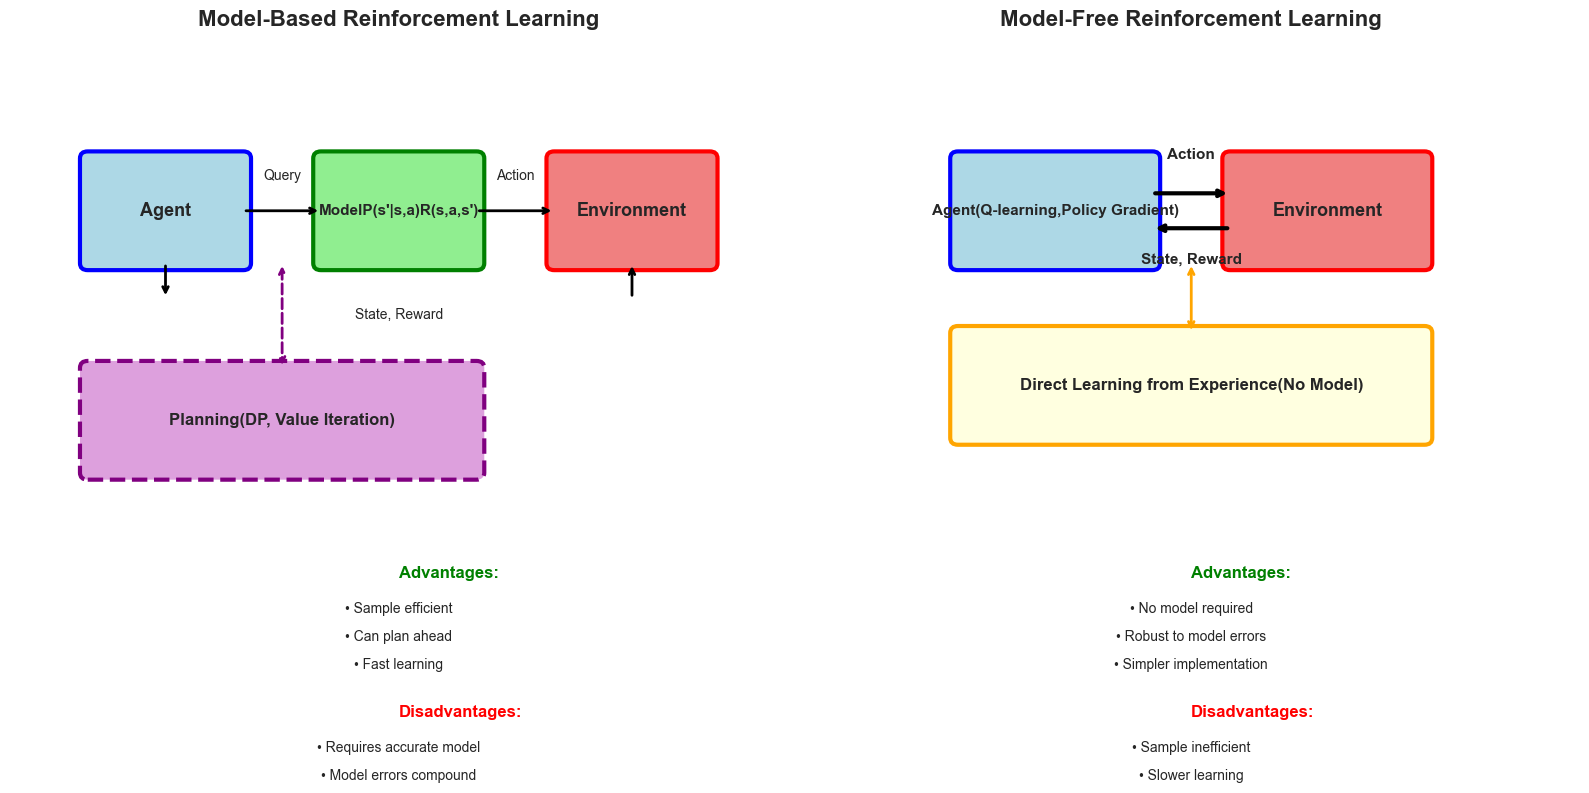

📊 Model-Based vs Model-Free RL
Model-Based RL (e.g., Dynamic Programming):
  • Uses model of environment (P, R)
  • Can plan without interacting
  • Sample efficient but requires accurate model
  • Examples: DP, Dyna, Model-based planning
Model-Free RL (e.g., Q-learning):
  • Learns directly from experience
  • No model of environment needed
  • Sample inefficient but robust
  • Examples: Monte Carlo, TD, Q-learning, Policy Gradients
🎯 Key Takeaway:
   Dynamic Programming is model-based - it requires perfect
   knowledge of the environment. In the next sections, we'll
   learn model-free methods that work without this knowledge!
   Model-free methods are essential for real-world RL where
   we don't have access to perfect models.


In [32]:
# Create a comparison visualization
import matplotlib.patches as mpatches

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Model-Based RL Diagram
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.axis('off')
ax1.set_title('Model-Based Reinforcement Learning', fontsize=16, fontweight='bold', pad=20)

# Agent
agent_box = mpatches.FancyBboxPatch((1, 7), 2, 1.5, boxstyle="round,pad=0.1", 
                                    edgecolor='blue', facecolor='lightblue', linewidth=3)
ax1.add_patch(agent_box)
ax1.text(2, 7.75, 'Agent', ha='center', va='center', fontsize=13, fontweight='bold')

# Model
model_box = mpatches.FancyBboxPatch((4, 7), 2, 1.5, boxstyle="round,pad=0.1", 
                                    edgecolor='green', facecolor='lightgreen', linewidth=3)
ax1.add_patch(model_box)
ax1.text(5, 7.75, 'ModelP(s\'|s,a)R(s,a,s\')', ha='center', va='center', fontsize=11, fontweight='bold')

# Environment
env_box = mpatches.FancyBboxPatch((7, 7), 2, 1.5, boxstyle="round,pad=0.1", 
                                  edgecolor='red', facecolor='lightcoral', linewidth=3)
ax1.add_patch(env_box)
ax1.text(8, 7.75, 'Environment', ha='center', va='center', fontsize=13, fontweight='bold')

# Arrows
ax1.annotate('', xy=(4, 7.75), xytext=(3, 7.75), 
            arrowprops=dict(arrowstyle='->', lw=2, color='black'))
ax1.text(3.5, 8.2, 'Query', ha='center', fontsize=10)

ax1.annotate('', xy=(7, 7.75), xytext=(6, 7.75), 
            arrowprops=dict(arrowstyle='->', lw=2, color='black'))
ax1.text(6.5, 8.2, 'Action', ha='center', fontsize=10)

ax1.annotate('', xy=(8, 7), xytext=(8, 6.5), 
            arrowprops=dict(arrowstyle='->', lw=2, color='black'))
ax1.annotate('', xy=(2, 7), xytext=(2, 6.5), 
            arrowprops=dict(arrowstyle='<-', lw=2, color='black'))
ax1.text(5, 6.2, 'State, Reward', ha='center', fontsize=10)

# Planning
plan_box = mpatches.FancyBboxPatch((1, 4), 5, 1.5, boxstyle="round,pad=0.1", 
                                   edgecolor='purple', facecolor='plum', linewidth=3, linestyle='--')
ax1.add_patch(plan_box)
ax1.text(3.5, 4.75, 'Planning(DP, Value Iteration)', ha='center', va='center', 
        fontsize=12, fontweight='bold')

ax1.annotate('', xy=(3.5, 5.5), xytext=(3.5, 7), 
            arrowprops=dict(arrowstyle='<->', lw=2, color='purple', linestyle='--'))

# Advantages/Disadvantages
ax1.text(5, 2.5, 'Advantages:', fontsize=12, fontweight='bold', color='green')
ax1.text(5, 2, '• Sample efficient', fontsize=10, ha='center')
ax1.text(5, 1.6, '• Can plan ahead', fontsize=10, ha='center')
ax1.text(5, 1.2, '• Fast learning', fontsize=10, ha='center')

ax1.text(5, 0.5, 'Disadvantages:', fontsize=12, fontweight='bold', color='red')
ax1.text(5, 0, '• Requires accurate model', fontsize=10, ha='center')
ax1.text(5, -0.4, '• Model errors compound', fontsize=10, ha='center')

# Model-Free RL Diagram
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')
ax2.set_title('Model-Free Reinforcement Learning', fontsize=16, fontweight='bold', pad=20)

# Agent
agent_box2 = mpatches.FancyBboxPatch((2, 7), 2.5, 1.5, boxstyle="round,pad=0.1", 
                                     edgecolor='blue', facecolor='lightblue', linewidth=3)
ax2.add_patch(agent_box2)
ax2.text(3.25, 7.75, 'Agent(Q-learning,Policy Gradient)', ha='center', va='center', 
        fontsize=11, fontweight='bold')

# Environment
env_box2 = mpatches.FancyBboxPatch((5.5, 7), 2.5, 1.5, boxstyle="round,pad=0.1", 
                                   edgecolor='red', facecolor='lightcoral', linewidth=3)
ax2.add_patch(env_box2)
ax2.text(6.75, 7.75, 'Environment', ha='center', va='center', fontsize=13, fontweight='bold')

# Direct interaction arrows
ax2.annotate('', xy=(5.5, 8), xytext=(4.5, 8), 
            arrowprops=dict(arrowstyle='->', lw=3, color='black'))
ax2.text(5, 8.5, 'Action', ha='center', fontsize=11, fontweight='bold')

ax2.annotate('', xy=(4.5, 7.5), xytext=(5.5, 7.5), 
            arrowprops=dict(arrowstyle='->', lw=3, color='black'))
ax2.text(5, 7, 'State, Reward', ha='center', fontsize=11, fontweight='bold')

# Direct learning
learn_box = mpatches.FancyBboxPatch((2, 4.5), 6, 1.5, boxstyle="round,pad=0.1", 
                                    edgecolor='orange', facecolor='lightyellow', linewidth=3)
ax2.add_patch(learn_box)
ax2.text(5, 5.25, 'Direct Learning from Experience(No Model)', ha='center', va='center', 
        fontsize=12, fontweight='bold')

ax2.annotate('', xy=(5, 6), xytext=(5, 7), 
            arrowprops=dict(arrowstyle='<->', lw=2, color='orange'))

# Advantages/Disadvantages
ax2.text(5, 2.5, 'Advantages:', fontsize=12, fontweight='bold', color='green')
ax2.text(5, 2, '• No model required', fontsize=10, ha='center')
ax2.text(5, 1.6, '• Robust to model errors', fontsize=10, ha='center')
ax2.text(5, 1.2, '• Simpler implementation', fontsize=10, ha='center')

ax2.text(5, 0.5, 'Disadvantages:', fontsize=12, fontweight='bold', color='red')
ax2.text(5, 0, '• Sample inefficient', fontsize=10, ha='center')
ax2.text(5, -0.4, '• Slower learning', fontsize=10, ha='center')

plt.tight_layout()
plt.show()

print("📊 Model-Based vs Model-Free RL")
print("="*60)
print("Model-Based RL (e.g., Dynamic Programming):")
print("  • Uses model of environment (P, R)")
print("  • Can plan without interacting")
print("  • Sample efficient but requires accurate model")
print("  • Examples: DP, Dyna, Model-based planning")

print("Model-Free RL (e.g., Q-learning):")
print("  • Learns directly from experience")
print("  • No model of environment needed")
print("  • Sample inefficient but robust")
print("  • Examples: Monte Carlo, TD, Q-learning, Policy Gradients")

print("" + "="*60)
print("🎯 Key Takeaway:")
print("   Dynamic Programming is model-based - it requires perfect")
print("   knowledge of the environment. In the next sections, we'll")
print("   learn model-free methods that work without this knowledge!")
print("   Model-free methods are essential for real-world RL where")
print("   we don't have access to perfect models.")

**Summary: Dynamic Programming and Learning Paradigms**

In this section, we've covered:

1. **Policy Evaluation**: Computing $V^\pi(s)$ for a given policy using iterative Bellman updates
2. **Policy Improvement**: Finding better policies by acting greedily with respect to value functions
3. **Value Iteration**: Efficiently finding optimal policies by combining evaluation and improvement
4. **Model-Based vs Model-Free**: Understanding when we need models and when we can learn without them

**Key Insights:**

- Dynamic Programming provides exact solutions when we have perfect models
- Policy iteration and value iteration both converge to optimal policies
- The Bellman equations are the foundation for all these algorithms
- Model-based methods are sample-efficient but require accurate models
- Model-free methods are more practical for real-world problems

**What's Next:**

In the following sections, we'll explore model-free methods that learn directly from experience:
- Monte Carlo methods (learn from complete episodes)
- Temporal Difference learning (learn from every step)
- Q-learning (off-policy TD control)
- Deep RL (handling large state spaces)

These methods form the foundation of modern reinforcement learning!

<a id='section2'></a>
## Section 2: Core Algorithms

In this section, we'll explore the fundamental algorithms that enable agents to learn optimal policies. We'll start with Monte Carlo methods, which learn from complete episodes, then progress to Temporal Difference methods that can learn from individual steps.

<a id='monte-carlo'></a>
### Monte Carlo Methods

**Learning from Complete Episodes**

Monte Carlo (MC) methods are a class of reinforcement learning algorithms that learn by averaging sample returns from complete episodes. Unlike Dynamic Programming, MC methods don't require a model of the environment - they learn directly from experience.

**The Core Principle:**

Monte Carlo methods estimate value functions by **averaging the actual returns** observed after visiting states. The key insight is:

*"The value of a state is the expected return starting from that state. If we experience many episodes and average the returns, we'll get a good estimate of the true value."*

**Key Characteristics:**

1. **Episode-Based Learning**: Must wait until episode ends to update values
2. **Model-Free**: Don't need to know transition probabilities or rewards
3. **Sample-Based**: Learn from actual experience, not from a model
4. **Unbiased Estimates**: Returns are actual outcomes, not bootstrapped estimates
5. **High Variance**: Individual returns can vary significantly

**When to Use Monte Carlo Methods:**

- ✓ Episodic tasks (games, simulations with clear endings)
- ✓ When you don't have a model of the environment
- ✓ When you can simulate or experience complete episodes
- ✗ Continuing tasks (no natural episode boundaries)
- ✗ When episodes are very long (slow learning)

**Comparison with Dynamic Programming:**

| Aspect | Dynamic Programming | Monte Carlo |
|--------|-------------------|-------------|
| Model Required | Yes (need P and R) | No (model-free) |
| Learning | From model | From experience |
| Updates | Every state | Only visited states |
| Bootstrapping | Yes (use estimates) | No (use actual returns) |
| Variance | Low | High |
| Bias | Depends on initialization | Unbiased |

Let's explore Monte Carlo methods in detail!

#### Monte Carlo Prediction: Estimating Value Functions

**The Goal:** Estimate the state-value function $V^\pi(s)$ for a given policy $\pi$.

**The Approach:** 
1. Follow policy $\pi$ to generate episodes
2. For each state visited, record the return (cumulative discounted reward)
3. Average the returns to estimate the value

**Two Variants: First-Visit vs Every-Visit MC**

**First-Visit Monte Carlo:**
- Only count the **first time** a state is visited in an episode
- Average returns from first visits only
- Theoretically guaranteed to converge to true value
- More commonly used in practice

**Every-Visit Monte Carlo:**
- Count **every time** a state is visited in an episode
- Average returns from all visits
- Also converges to true value
- Can learn faster in some cases

**Mathematical Formulation:**

For a state $s$ visited at time $t$ in an episode:

**Return from that visit:**
$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$

**Value estimate (after $n$ visits):**
$V(s) = \frac{1}{n} \sum_{i=1}^{n} G_i(s)$

where $G_i(s)$ is the return following the $i$-th visit to state $s$.

**Incremental Update Formula:**

Instead of storing all returns and averaging, we can update incrementally:

$V(s) \leftarrow V(s) + \frac{1}{N(s)} [G - V(s)]$

where:
- $N(s)$ = number of times state $s$ has been visited
- $G$ = return observed from this visit
- $\frac{1}{N(s)}$ = step size (learning rate)

This is equivalent to:
$V(s) \leftarrow V(s) + \alpha [G - V(s)]$

where $\alpha$ is a constant step size (useful for non-stationary problems).

Let's implement both first-visit and every-visit Monte Carlo prediction:

In [33]:
def generate_episode(env, policy, max_steps=100):
    """Generate an episode following a given policy.
    
    Args:
        env: Environment with reset() and step() methods
        policy: Function that takes state and returns action
        max_steps: Maximum steps per episode
        
    Returns:
        episode: List of (state, action, reward) tuples
    """
    episode = []
    state = env.reset()
    
    for _ in range(max_steps):
        action = policy(state)
        next_state, reward, done, _ = env.step(action)
        
        episode.append((state, action, reward))
        
        if done:
            break
        
        state = next_state
    
    return episode


def calculate_returns(episode, gamma=0.9):
    """Calculate returns for each step in an episode.
    
    Args:
        episode: List of (state, action, reward) tuples
        gamma: Discount factor
        
    Returns:
        returns: List of returns, one for each step
    """
    returns = []
    G = 0
    
    # Calculate returns backwards from end of episode
    for state, action, reward in reversed(episode):
        G = reward + gamma * G
        returns.insert(0, G)  # Insert at beginning to maintain order
    
    return returns


def mc_prediction_first_visit(env, policy, num_episodes=1000, gamma=0.9):
    """First-visit Monte Carlo prediction.
    
    Estimates V(s) by averaging returns from first visits to each state.
    
    Args:
        env: Environment
        policy: Policy to evaluate (function: state -> action)
        num_episodes: Number of episodes to generate
        gamma: Discount factor
        
    Returns:
        V: Dictionary mapping states to estimated values
        returns_history: List of returns for each episode (for visualization)
    """
    # Initialize value function and visit counts
    V = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    returns_history = []
    
    for episode_num in range(num_episodes):
        # Generate episode
        episode = generate_episode(env, policy)
        
        # Calculate returns
        returns = calculate_returns(episode, gamma)
        
        # Track total return for this episode
        returns_history.append(returns[0] if returns else 0)
        
        # Track which states we've seen in this episode (for first-visit)
        visited_states = set()
        
        # Update value estimates
        for t, (state, action, reward) in enumerate(episode):
            # First-visit: only update if this is the first time seeing this state
            if state not in visited_states:
                visited_states.add(state)
                
                # Add return to sum
                returns_sum[state] += returns[t]
                returns_count[state] += 1
                
                # Update value estimate (average of returns)
                V[state] = returns_sum[state] / returns_count[state]
    
    return dict(V), returns_history


def mc_prediction_every_visit(env, policy, num_episodes=1000, gamma=0.9):
    """Every-visit Monte Carlo prediction.
    
    Estimates V(s) by averaging returns from all visits to each state.
    
    Args:
        env: Environment
        policy: Policy to evaluate (function: state -> action)
        num_episodes: Number of episodes to generate
        gamma: Discount factor
        
    Returns:
        V: Dictionary mapping states to estimated values
        returns_history: List of returns for each episode (for visualization)
    """
    # Initialize value function and visit counts
    V = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    returns_history = []
    
    for episode_num in range(num_episodes):
        # Generate episode
        episode = generate_episode(env, policy)
        
        # Calculate returns
        returns = calculate_returns(episode, gamma)
        
        # Track total return for this episode
        returns_history.append(returns[0] if returns else 0)
        
        # Update value estimates
        for t, (state, action, reward) in enumerate(episode):
            # Every-visit: update for every occurrence of the state
            returns_sum[state] += returns[t]
            returns_count[state] += 1
            
            # Update value estimate (average of returns)
            V[state] = returns_sum[state] / returns_count[state]
    
    return dict(V), returns_history


print("Monte Carlo Prediction Implementation")
print("="*60)
print("Implemented:")
print("  ✓ First-Visit MC Prediction")
print("  ✓ Every-Visit MC Prediction")
print("  ✓ Episode generation")
print("  ✓ Return calculation")
print("Ready to evaluate policies on episodic environments!")

Monte Carlo Prediction Implementation
Implemented:
  ✓ First-Visit MC Prediction
  ✓ Every-Visit MC Prediction
  ✓ Episode generation
  ✓ Return calculation
Ready to evaluate policies on episodic environments!


#### Demonstrating Monte Carlo Prediction on Grid World

In [34]:
# Create a simple policy for the grid world
def random_policy(state):
    """Random policy: choose actions uniformly at random."""
    return np.random.randint(0, 4)  # 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT


def greedy_policy(state):
    """Greedy policy: always move toward goal (4,4)."""
    row, col = state
    goal_row, goal_col = 4, 4
    
    # Move right if not at rightmost column
    if col < goal_col:
        return 1  # RIGHT
    # Move down if not at bottom row
    elif row < goal_row:
        return 2  # DOWN
    # Otherwise move randomly
    else:
        return np.random.randint(0, 4)


print("Evaluating Policies with Monte Carlo Prediction")
print("="*60)

# Create environment
env = GridWorldEnvironment(grid_size=5)

print("Environment: 5x5 Grid World")
print(f"  Start: (0,0)")
print(f"  Goal: {env.goal_pos}")
print(f"  Obstacles: {env.obstacles}")

# Evaluate random policy
print("" + "-"*60)
print("Evaluating Random Policy with First-Visit MC...")
V_random_fv, returns_random_fv = mc_prediction_first_visit(
    env, random_policy, num_episodes=5000, gamma=0.9
)

print("Evaluating Random Policy with Every-Visit MC...")
V_random_ev, returns_random_ev = mc_prediction_every_visit(
    env, random_policy, num_episodes=5000, gamma=0.9
)

# Evaluate greedy policy
print("Evaluating Greedy Policy with First-Visit MC...")
V_greedy_fv, returns_greedy_fv = mc_prediction_first_visit(
    env, greedy_policy, num_episodes=5000, gamma=0.9
)

print("Evaluating Greedy Policy with Every-Visit MC...")
V_greedy_ev, returns_greedy_ev = mc_prediction_every_visit(
    env, greedy_policy, num_episodes=5000, gamma=0.9
)

print("" + "="*60)
print("✓ Evaluation complete!")
print(f"Random Policy:")
print(f"  States evaluated: {len(V_random_fv)}")
print(f"  Start state value (First-Visit): {V_random_fv.get((0,0), 0):.2f}")
print(f"  Start state value (Every-Visit): {V_random_ev.get((0,0), 0):.2f}")

print(f"Greedy Policy:")
print(f"  States evaluated: {len(V_greedy_fv)}")
print(f"  Start state value (First-Visit): {V_greedy_fv.get((0,0), 0):.2f}")
print(f"  Start state value (Every-Visit): {V_greedy_ev.get((0,0), 0):.2f}")

print("💡 Observation: Greedy policy has higher value (reaches goal faster)")

Evaluating Policies with Monte Carlo Prediction
Environment: 5x5 Grid World
  Start: (0,0)
  Goal: (4, 4)
  Obstacles: [(2, 2), (3, 2)]
------------------------------------------------------------
Evaluating Random Policy with First-Visit MC...
Evaluating Random Policy with Every-Visit MC...
Evaluating Greedy Policy with First-Visit MC...
Evaluating Greedy Policy with Every-Visit MC...
✓ Evaluation complete!
Random Policy:
  States evaluated: 22
  Start state value (First-Visit): -0.79
  Start state value (Every-Visit): -0.80
Greedy Policy:
  States evaluated: 8
  Start state value (First-Visit): 4.26
  Start state value (Every-Visit): 4.26
💡 Observation: Greedy policy has higher value (reaches goal faster)


#### Visualizing Value Function Convergence

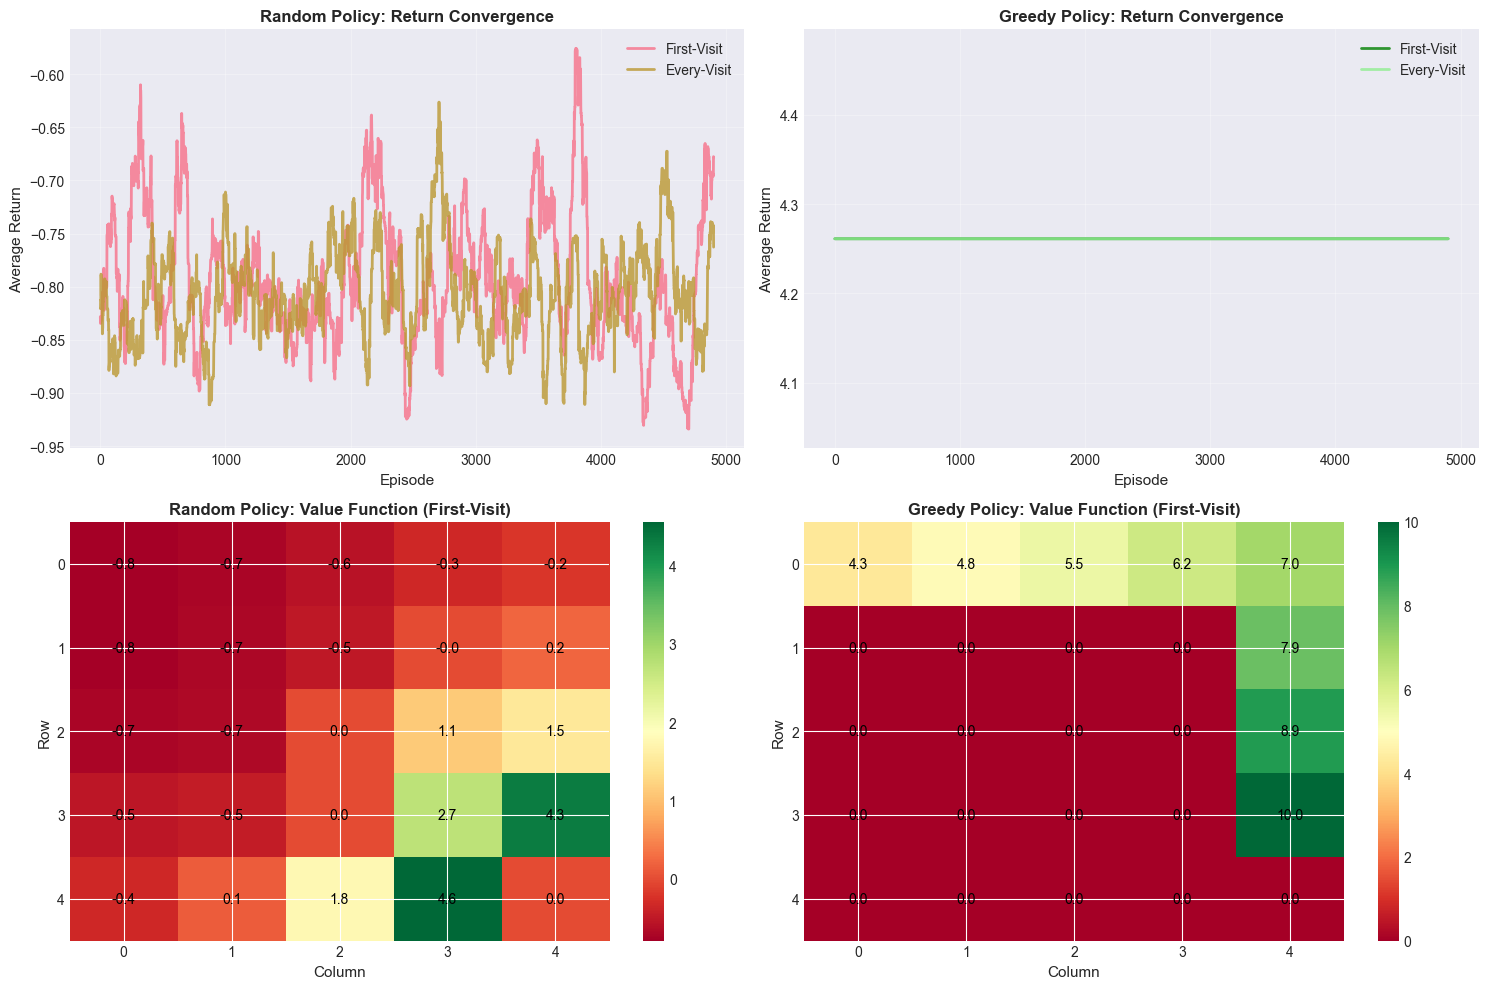

📊 Visualization Insights:
1. Top Row: Returns converge as more episodes are sampled
   - First-visit and every-visit produce similar estimates
   - Greedy policy achieves higher returns than random
2. Bottom Row: Value function heatmaps
   - Brighter colors = higher values (closer to goal)
   - Values increase as we approach goal state (4,4)
   - Greedy policy has higher values overall
3. Key Takeaway:
   Monte Carlo successfully estimates state values from experience!
   No model required - just sample episodes and average returns.


In [35]:
# Visualize how value estimates converge over episodes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Random Policy - Returns over episodes
ax = axes[0, 0]
window = 100
smoothed_random_fv = np.convolve(returns_random_fv, np.ones(window)/window, mode='valid')
smoothed_random_ev = np.convolve(returns_random_ev, np.ones(window)/window, mode='valid')

ax.plot(smoothed_random_fv, label='First-Visit', linewidth=2, alpha=0.8)
ax.plot(smoothed_random_ev, label='Every-Visit', linewidth=2, alpha=0.8)
ax.set_xlabel('Episode', fontsize=11)
ax.set_ylabel('Average Return', fontsize=11)
ax.set_title('Random Policy: Return Convergence', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Greedy Policy - Returns over episodes
ax = axes[0, 1]
smoothed_greedy_fv = np.convolve(returns_greedy_fv, np.ones(window)/window, mode='valid')
smoothed_greedy_ev = np.convolve(returns_greedy_ev, np.ones(window)/window, mode='valid')

ax.plot(smoothed_greedy_fv, label='First-Visit', linewidth=2, alpha=0.8, color='green')
ax.plot(smoothed_greedy_ev, label='Every-Visit', linewidth=2, alpha=0.8, color='lightgreen')
ax.set_xlabel('Episode', fontsize=11)
ax.set_ylabel('Average Return', fontsize=11)
ax.set_title('Greedy Policy: Return Convergence', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Value function heatmap for Random Policy (First-Visit)
ax = axes[1, 0]
value_grid = np.zeros((5, 5))
for (row, col), value in V_random_fv.items():
    value_grid[row, col] = value

im = ax.imshow(value_grid, cmap='RdYlGn', aspect='auto')
ax.set_title('Random Policy: Value Function (First-Visit)', fontsize=12, fontweight='bold')
ax.set_xlabel('Column', fontsize=11)
ax.set_ylabel('Row', fontsize=11)

# Add value labels
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, f'{value_grid[i, j]:.1f}',
                      ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im, ax=ax)

# Plot 4: Value function heatmap for Greedy Policy (First-Visit)
ax = axes[1, 1]
value_grid = np.zeros((5, 5))
for (row, col), value in V_greedy_fv.items():
    value_grid[row, col] = value

im = ax.imshow(value_grid, cmap='RdYlGn', aspect='auto')
ax.set_title('Greedy Policy: Value Function (First-Visit)', fontsize=12, fontweight='bold')
ax.set_xlabel('Column', fontsize=11)
ax.set_ylabel('Row', fontsize=11)

# Add value labels
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, f'{value_grid[i, j]:.1f}',
                      ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("📊 Visualization Insights:")
print("1. Top Row: Returns converge as more episodes are sampled")
print("   - First-visit and every-visit produce similar estimates")
print("   - Greedy policy achieves higher returns than random")

print("2. Bottom Row: Value function heatmaps")
print("   - Brighter colors = higher values (closer to goal)")
print("   - Values increase as we approach goal state (4,4)")
print("   - Greedy policy has higher values overall")

print("3. Key Takeaway:")
print("   Monte Carlo successfully estimates state values from experience!")
print("   No model required - just sample episodes and average returns.")

#### On-Policy Monte Carlo Control

**From Prediction to Control: Learning Optimal Policies**

So far, we've used Monte Carlo methods for **prediction** - evaluating a given policy. Now we'll use MC for **control** - finding the optimal policy.

**The Control Problem:**

Given: An environment (MDP without model)
Goal: Find the optimal policy $\pi^*$ that maximizes expected return

**On-Policy Learning:**

In **on-policy** learning, we learn about and improve the same policy that we're using to generate behavior. The agent:
1. Acts according to policy $\pi$
2. Learns from that experience
3. Improves policy $\pi$
4. Repeats

This contrasts with **off-policy** learning (covered later), where the agent learns about one policy while following another.

**The Algorithm: Monte Carlo Control with Epsilon-Greedy**

We can't use a purely greedy policy (always exploit) because we need exploration. The solution: **epsilon-greedy exploration**.

**Key Idea:** Instead of learning $V(s)$, we learn $Q(s,a)$ (action-values), which tells us the value of taking action $a$ in state $s$.

**Algorithm Steps:**

1. **Initialize**: 
   - $Q(s,a) = 0$ for all states and actions
   - $\pi$ = epsilon-greedy policy based on $Q$

2. **Repeat** for many episodes:
   - **Generate episode** following $\pi$: $S_0, A_0, R_1, S_1, A_1, R_2, ..., S_T$
   - **For each** state-action pair $(s,a)$ in the episode:
     - Calculate return $G$ following first visit to $(s,a)$
     - Update: $Q(s,a) \leftarrow \text{average of returns following } (s,a)$
   - **Improve policy**: $\pi \leftarrow$ epsilon-greedy with respect to $Q$

**Epsilon-Greedy Policy:**

$\pi(a|s) = \begin{cases}
1 - \epsilon + \frac{\epsilon}{|A(s)|} & \text{if } a = \arg\max_{a'} Q(s,a') \\
\frac{\epsilon}{|A(s)|} & \text{otherwise}
\end{cases}$

**Why This Works:**

1. **Exploration**: Epsilon-greedy ensures all actions are tried
2. **Exploitation**: Mostly choose actions with highest Q-values
3. **Improvement**: Policy gets better as Q-values become more accurate
4. **Convergence**: Under certain conditions, converges to optimal epsilon-greedy policy

**Generalized Policy Iteration (GPI):**

MC Control is an instance of GPI:
- **Policy Evaluation**: Estimate $Q^\pi$ using MC sampling
- **Policy Improvement**: Make policy greedy with respect to $Q$
- **Iterate**: These two processes work together to find $\pi^*$

Let's implement on-policy MC control:

In [36]:
class EpsilonGreedyPolicy:
    """Epsilon-greedy policy based on Q-values."""
    
    def __init__(self, epsilon=0.1, num_actions=4):
        """Initialize epsilon-greedy policy.
        
        Args:
            epsilon: Probability of random action
            num_actions: Number of possible actions
        """
        self.epsilon = epsilon
        self.num_actions = num_actions
        self.Q = defaultdict(lambda: np.zeros(num_actions))
    
    def get_action(self, state):
        """Select action using epsilon-greedy strategy.
        
        Args:
            state: Current state
            
        Returns:
            action: Selected action
        """
        if np.random.random() < self.epsilon:
            # Explore: random action
            return np.random.randint(0, self.num_actions)
        else:
            # Exploit: best action according to Q
            return np.argmax(self.Q[state])
    
    def get_greedy_action(self, state):
        """Get the greedy action (for evaluation)."""
        return np.argmax(self.Q[state])


def mc_control_on_policy(env, num_episodes=10000, gamma=0.9, epsilon=0.1):
    """On-policy Monte Carlo control with epsilon-greedy exploration.
    
    Learns optimal policy by:
    1. Generating episodes with epsilon-greedy policy
    2. Updating Q-values from returns
    3. Improving policy to be greedy w.r.t. Q
    
    Args:
        env: Environment
        num_episodes: Number of episodes to run
        gamma: Discount factor
        epsilon: Exploration probability
        
    Returns:
        policy: Learned epsilon-greedy policy
        Q: Learned action-value function
        stats: Dictionary with learning statistics
    """
    # Initialize policy
    policy = EpsilonGreedyPolicy(epsilon=epsilon, num_actions=4)
    
    # Track returns for each state-action pair
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    
    # Statistics for tracking progress
    episode_returns = []
    episode_lengths = []
    
    for episode_num in range(num_episodes):
        # Generate episode using current policy
        episode = generate_episode(env, policy.get_action, max_steps=100)
        
        # Calculate returns
        returns = calculate_returns(episode, gamma)
        
        # Track statistics
        episode_returns.append(returns[0] if returns else 0)
        episode_lengths.append(len(episode))
        
        # Track visited state-action pairs (for first-visit)
        visited_pairs = set()
        
        # Update Q-values
        for t, (state, action, reward) in enumerate(episode):
            pair = (state, action)
            
            # First-visit MC
            if pair not in visited_pairs:
                visited_pairs.add(pair)
                
                # Update return statistics
                returns_sum[pair] += returns[t]
                returns_count[pair] += 1
                
                # Update Q-value (average of returns)
                policy.Q[state][action] = returns_sum[pair] / returns_count[pair]
        
        # Policy improvement happens automatically through epsilon-greedy
        # (policy always acts epsilon-greedy w.r.t. current Q)
    
    stats = {
        'episode_returns': episode_returns,
        'episode_lengths': episode_lengths,
        'states_visited': len(policy.Q)
    }
    
    return policy, dict(policy.Q), stats


print("On-Policy Monte Carlo Control Implementation")
print("="*60)
print("Implemented:")
print("  ✓ Epsilon-greedy policy class")
print("  ✓ On-policy MC control algorithm")
print("  ✓ Q-value learning from episodes")
print("  ✓ Policy improvement through GPI")
print("Ready to learn optimal policies!")

On-Policy Monte Carlo Control Implementation
Implemented:
  ✓ Epsilon-greedy policy class
  ✓ On-policy MC control algorithm
  ✓ Q-value learning from episodes
  ✓ Policy improvement through GPI
Ready to learn optimal policies!


#### Learning Optimal Policy in Grid World

In [37]:
# Learn optimal policy using MC control
print("Learning Optimal Policy with On-Policy MC Control")
print("="*60)

# Create environment
env = GridWorldEnvironment(grid_size=5)

print("Environment: 5x5 Grid World")
print(f"  Start: (0,0)")
print(f"  Goal: {env.goal_pos}")
print(f"  Obstacles: {env.obstacles}")
print(f"  Actions: {env.actions}")

print("Training agent with MC control...")
print("  Episodes: 10,000")
print("  Epsilon: 0.1")
print("  Gamma: 0.9")

# Train agent
policy, Q, stats = mc_control_on_policy(
    env, 
    num_episodes=10000, 
    gamma=0.9, 
    epsilon=0.1
)

print("✓ Training complete!")
print(f"Learning Statistics:")
print(f"  States visited: {stats['states_visited']}")
print(f"  Final average return: {np.mean(stats['episode_returns'][-100:]):.2f}")
print(f"  Final average episode length: {np.mean(stats['episode_lengths'][-100:]):.1f}")

# Show learned policy for some key states
print("Learned Policy (greedy actions):")
print("-" * 40)
key_states = [(0,0), (0,1), (1,0), (2,0), (3,3), (4,3)]
for state in key_states:
    if state in Q:
        action = policy.get_greedy_action(state)
        action_name = env.actions[action]
        q_values = Q[state]
        print(f"  State {state}: {action_name} (Q-values: {q_values})")

print("" + "="*60)

Learning Optimal Policy with On-Policy MC Control
Environment: 5x5 Grid World
  Start: (0,0)
  Goal: (4, 4)
  Obstacles: [(2, 2), (3, 2)]
  Actions: ['UP', 'RIGHT', 'DOWN', 'LEFT']
Training agent with MC control...
  Episodes: 10,000
  Epsilon: 0.1
  Gamma: 0.9
✓ Training complete!
Learning Statistics:
  States visited: 22
  Final average return: 3.71
  Final average episode length: 9.2
Learned Policy (greedy actions):
----------------------------------------
  State (0, 0): DOWN (Q-values: [3.22330238 3.11577019 3.77937366 3.20119993])
  State (0, 1): RIGHT (Q-values: [2.51045144 4.34098292 2.57047803 3.24625689])
  State (1, 0): RIGHT (Q-values: [3.20110505 4.37906645 3.23522956 3.74808745])
  State (2, 0): UP (Q-values: [3.78899803 2.8904143  2.51156957 2.28918843])
  State (3, 3): RIGHT (Q-values: [6.78589881 8.75195447 8.7415328  7.72862734])
  State (4, 3): RIGHT (Q-values: [ 7.54087143 10.          8.42975     6.79625857])
